# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# checking to see how many interactions we have overall

df.shape

(45993, 3)

In [4]:
# checking count of values - we see email has less
df.count()

article_id    45993
title         45993
email         45976
dtype: int64

In [5]:
# checking null values - we have 17 null values in the email column, where info is not available

df.isnull().sum() 

article_id     0
title          0
email         17
dtype: int64

In [6]:
#  checking unique values in each column in df
# we have 5148 distinct users, interacting overall with 714 articles
# we have some NaN values in the email column

print(df.nunique(dropna=True))
print(df.nunique(dropna=False))

article_id     714
title          714
email         5148
dtype: int64
article_id     714
title          714
email         5149
dtype: int64


In [7]:
#  checking unique values in each column in df_content
# we have 1051 distinct ids/articles

print(df_content.nunique(dropna=True))
print(df_content.nunique(dropna=False))

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64
doc_body           1037
doc_description    1023
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64


In [8]:
# checking if all ids from  user-item-interactions are included in articles_community- they are not

# we get all unique article ids from both data sets
user_item_ids = np.array(df['article_id'].unique())
art_comm_ids = np.array(df_content['article_id'].unique())

# we do difference from both sides (what is in list 1, and not in list 2, and viceversa)
dif1 = np.setdiff1d(user_item_ids, art_comm_ids)
dif2 = np.setdiff1d(art_comm_ids, user_item_ids)

print('Number of articles present in interactions, not available in community is: {}'.format(len(dif1)))
print('Number of articles present in community, not available in interactions is: {}'.format(len(dif2)))


Number of articles present in interactions, not available in community is: 277
Number of articles present in community, not available in interactions is: 614


,email,interaction_cnt
0,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
1,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
4,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
5,f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76,158
6,284d0c17905de71e209b376e3309c0b08134f7e2,148
7,18e7255ee311d4bd78f5993a9f09538e459e3fcc,147
8,d9032ff68d0fd45dfd18c0c5f7324619bb55362c,147
9,276d9d8ca0bf52c780b5a3fc554fa69e74f934a3,145


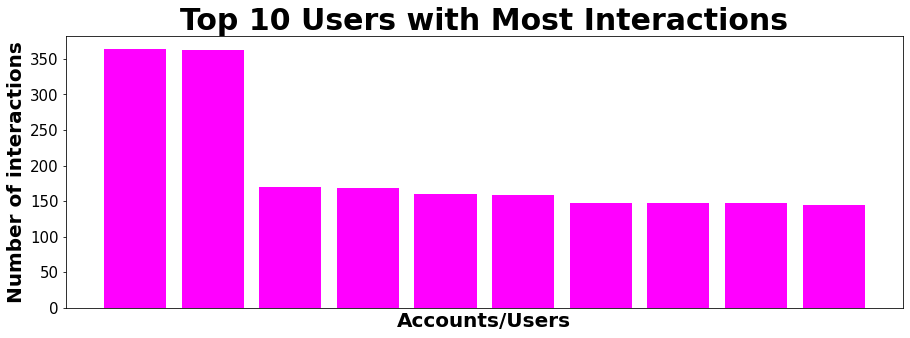

In [9]:
# checking to see how many interactions top 10 users have, and sorting data from highest to lower

df_usr_inter=df.groupby(['email']).agg(interaction_cnt=('article_id', 'count')).sort_values(['interaction_cnt'], ascending=False)
df_usr_inter_top10=df_usr_inter.reset_index().head(10)
display(df_usr_inter_top10)

# plotting the results

fig = plt.figure(figsize = (15, 5))
plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
plt.bar(df_usr_inter_top10['email'], df_usr_inter_top10['interaction_cnt'], color='magenta')
plt.xlabel("Accounts/Users", fontweight ='bold', fontsize = 20)
plt.ylabel("Number of interactions", fontweight ='bold', fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("Top 10 Users with Most Interactions", fontweight ='bold', fontsize = 30)
plt.show()

,email,article_cnt
0,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,135
1,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,135
2,d9032ff68d0fd45dfd18c0c5f7324619bb55362c,101
3,c60bb0a50c324dad0bffd8809d121246baef372b,100
4,a37adec71b667b297ed2440a9ff7dad427c7ac85,97
5,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,97
6,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,96
7,f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76,96
8,276d9d8ca0bf52c780b5a3fc554fa69e74f934a3,75
9,56832a697cb6dbce14700fca18cffcced367057f,75


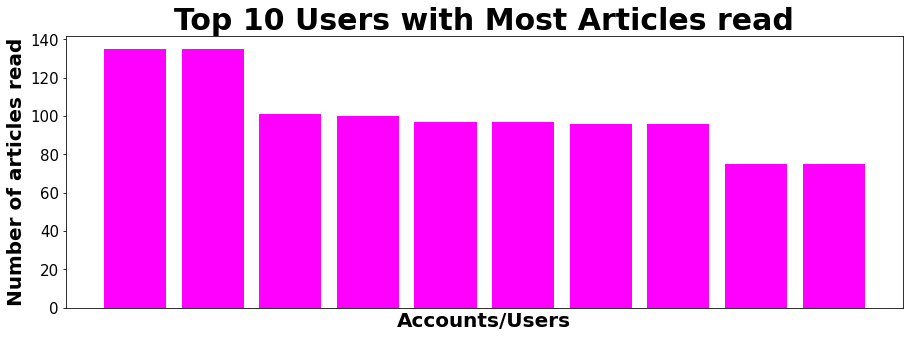

In [10]:
# checking top 10 users with most articles read

df_usr_art=df.groupby(['email']).agg(article_cnt=('article_id', pd.Series.nunique)).sort_values(['article_cnt'], ascending=False)
df_usr_art_top10=df_usr_art.reset_index().head(10)
display(df_usr_art_top10)

# plotting the results

fig = plt.figure(figsize = (15, 5))
plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
plt.bar(df_usr_art_top10['email'], df_usr_art_top10['article_cnt'], color='magenta')
plt.xlabel("Accounts/Users", fontweight ='bold', fontsize = 20)
plt.ylabel("Number of articles read", fontweight ='bold', fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("Top 10 Users with Most Articles read", fontweight ='bold', fontsize = 30)
plt.show()

In [11]:
import math   

# Checking the main metrics for the unique list of users, and the number of unique articles they interacted with

df_usr_art=df.groupby(['email']).agg(article_cnt=('article_id', pd.Series.nunique)).sort_values(['article_cnt'], ascending=False)
display(df_usr_art.describe())

# checking the number of maximum unique articles read by users within the lower half of the list

df_usr_art=df_usr_art.reset_index()
half_users=math.floor(df_usr_art['email'].unique().size/2)
display(df_usr_art.iloc[half_users:, :].head(5))

,article_cnt
count,5148.000000
mean,6.540210
std,9.990676
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,135.000000


,email,article_cnt
2574,d470b1ea3041a1b46dd1b57e68ad71e14037c5c9,3
2575,11b790a14d583b8fcea17af698c1e7c7382edec6,3
2576,741202fbcdc3113265b65e38734745c883981752,3
2577,61fab61648ca188a862eedfaeb2fa9ada07c1a23,3
2578,d4a2fcfa3d69ddb157fa3c7816cb444cdcedd913,3


,article_id,title,interaction_cnt
0,1429.0,use deep learning for image classification,937
1,1330.0,insights from new york car accident reports,927
2,1431.0,visualize car data with brunel,671
3,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643
4,1364.0,predicting churn with the spss random tree alg...,627
5,1314.0,healthcare python streaming application demo,614
6,1293.0,finding optimal locations of new store using d...,572
7,1170.0,"apache spark lab, part 1: basic concepts",565
8,1162.0,analyze energy consumption in buildings,512
9,1304.0,gosales transactions for logistic regression m...,483


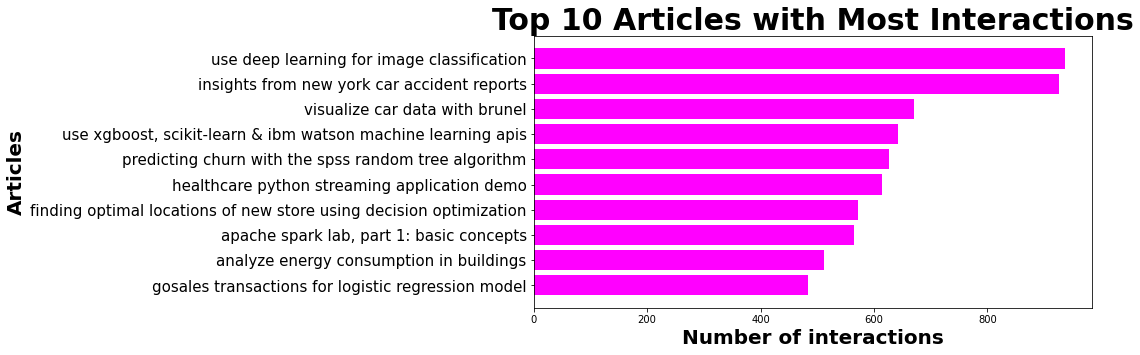

In [12]:
# top 10 articles most interacted with

df_art_inter=df.groupby(['article_id' , 'title']).agg(interaction_cnt=('email', 'count')).sort_values(['interaction_cnt'], ascending=False)

#  plotting the results

df_art_inter_top10=df_art_inter.reset_index().head(10).sort_values(['interaction_cnt'])
display(df_art_inter_top10.sort_values(['interaction_cnt'],ascending=False))

fig = plt.figure(figsize = (10, 5))
plt.barh(df_art_inter_top10['title'], df_art_inter_top10['interaction_cnt'], color='magenta')
plt.xlabel("Number of interactions", fontweight ='bold', fontsize = 20)
plt.ylabel("Articles", fontweight ='bold', fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("Top 10 Articles with Most Interactions", fontweight ='bold', fontsize = 30)
plt.show()

,article_id,title,interaction_cnt
0,1092.0,airbnb data for analytics: london reviews,1
17,1127.0,airbnb data for analytics: san diego listings,1
16,675.0,webinar: april 11 - thinking inside the box: y...,1
15,1119.0,airbnb data for analytics: oakland reviews,1
14,653.0,create a connection and add it to a project us...,1
13,662.0,build deep learning architectures with neural ...,1
12,974.0,"this week in data science (november 22, 2016)",1
11,1344.0,measles immunization % children 12-23 months b...,1
10,1113.0,airbnb data for analytics: new orleans reviews,1
9,724.0,nips 2016 — day 2 highlights,1


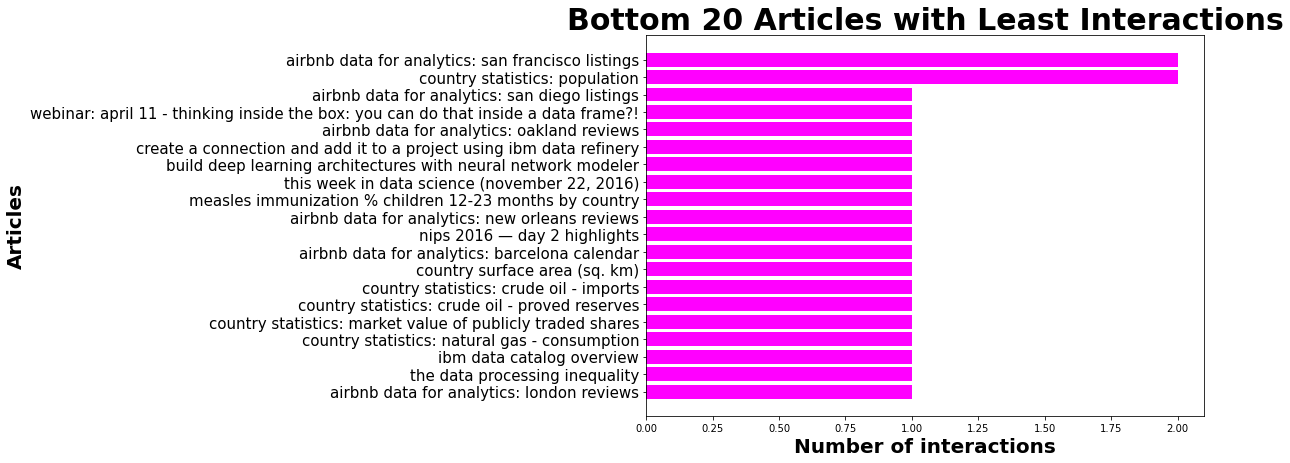

In [13]:
# checking to see bottom 20 articles with the least interactions

df_art_inter_min=df.groupby(['article_id' ,'title']).agg(interaction_cnt=('email', 'count')).sort_values(['interaction_cnt'], ascending=True)

#  plotting the results

df_art_inter_min=df_art_inter_min.reset_index().head(20)
display(df_art_inter_min.sort_values(['interaction_cnt'], ascending=True ))
fig = plt.figure(figsize = (10, 7))
plt.barh(df_art_inter_min['title'], df_art_inter_min['interaction_cnt'], color='magenta')
plt.xlabel("Number of interactions", fontweight ='bold', fontsize = 20)
plt.ylabel("Articles", fontweight ='bold', fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("Bottom 20 Articles with Least Interactions", fontweight ='bold', fontsize = 30)
plt.show()

In [14]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [15]:
# checking df_content a bit again

display(df_content.head(5))

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [16]:
# checking to see how many rows we have in the content data overall

df_content.shape

(1056, 5)

In [17]:
# checking to see if we have any duplicated rows across all columns- no rows are duplicated across all columns

display(df_content[df_content.duplicated()])
display(df_content[df_content.duplicated()].shape[0])

,doc_body,doc_description,doc_full_name,doc_status,article_id


0

In [18]:
# checking to see if we have any duplicated info per column - article_id especially
# we have 5 article_ids that are duplicated - 10 rows in total

display(df_content[df_content.duplicated(['article_id'], keep=False)])
dupl_ids=df_content[df_content.duplicated(['article_id'])]['article_id'].unique()
print(dupl_ids)

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


[ 50 221 398 577 232]


In [19]:
#  checking how many rows we have that have same info in article_id, doc_full_name, and doc_description
# we have 2 articles that have duplicated info for the  article_id, doc_full_name, and doc_description columns- 4 rows in total

display(df_content[df_content.duplicated(['article_id', 'doc_full_name', 'doc_description'], keep=False)])

,doc_body,doc_description,doc_full_name,doc_status,article_id
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [20]:
# Remove any rows that have the same article_id - only keep the first
# below taken from https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/

df_content_un = df_content.drop_duplicates(subset='article_id', keep='first')
print(df_content_un.shape)

(1051, 5)


In [21]:
# checking to see if the duplicated article_ids were dropped - they were all dropped

display(df_content_un[df_content_un.duplicated(['article_id'], keep=False)])
dupl_ids_new=df_content_un[df_content_un.duplicated(['article_id'])]['article_id'].unique()

print(dupl_ids_new)

,doc_body,doc_description,doc_full_name,doc_status,article_id


[]


In [22]:
# checking to see if the first row was kept indeed - it was

display(df_content[df_content.duplicated(['article_id'], keep=False)])
display(df_content_un[df_content_un['article_id'].isin(dupl_ids)])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [23]:
# we check all unique articles df calculated earlier

df_art_inter=df_art_inter.reset_index()
display(df_art_inter)

,article_id,title,interaction_cnt
0,1429.0,use deep learning for image classification,937
1,1330.0,insights from new york car accident reports,927
2,1431.0,visualize car data with brunel,671
3,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643
4,1364.0,predicting churn with the spss random tree alg...,627
...,...,...,...
709,1113.0,airbnb data for analytics: new orleans reviews,1
710,1119.0,airbnb data for analytics: oakland reviews,1
711,984.0,the data processing inequality,1
712,1127.0,airbnb data for analytics: san diego listings,1


In [24]:
# merging the df_content and the df_art_inter

unique_articles_df= pd.merge(df_content, df_art_inter, how='inner', on='article_id')
print('Unique articles with at least 1 interaction in articles_community: {}'.format(unique_articles_df.shape[0]))
print('Unique articles with at least 1 interaction in user-item-interactions: {}'.format(df_art_inter.shape[0]))
print('The number of unique users is: {}'.format(df_usr_art.shape[0]))
print('The number of user-article interactions is: {}'.format(df.shape[0]))

Unique articles with at least 1 interaction in articles_community: 441
Unique articles with at least 1 interaction in user-item-interactions: 714
The number of unique users is: 5148
The number of user-article interactions is: 45993


In [25]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [26]:
df_art_inter_top10.loc[0,:]

article_id                                             1429.0
title              use deep learning for image classification
interaction_cnt                                           937
Name: 0, dtype: object

In [27]:
most_viewed_article_id ='1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [28]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
df['user_id'].nunique()

5149

In [30]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [31]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    df_top_n=df.groupby(['article_id', 'title']).agg(interaction_cnt=('article_id', 'count')).sort_values(['interaction_cnt'], ascending=False).reset_index().head(n)
    top_articles=df_top_n['title'].values.tolist()
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    df_top_n=df.groupby(['article_id', 'title']).agg(interaction_cnt=('article_id', 'count')).sort_values(['interaction_cnt'], ascending=False).reset_index().head(n)
    top_articles=df_top_n['article_id'].values.tolist()
    
    return top_articles # Return the top article ids

In [32]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [33]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [34]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    # Create user-by-item matrix
    
    user_item=df.groupby(['user_id', 'article_id'])['title'].count().reset_index()
    user_item['cnt']=1
    
    # Below taken from the 4_Collaborative Filtering exercise
    user_item = user_item.groupby(['user_id', 'article_id'])['cnt'].max().unstack().replace(np.nan, 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [35]:
display(user_item.head(10))

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [37]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # create list of just the ids
    # remove the own user's id
    
    sim=[]
    most_similar_users=[]
    
    for user in range(user_item.shape[0]):
        
        # I had to deduct one for the user_id, as the user_item.shape[0] starts at 0, and the user_ids start at 1
        if  (user+1) != user_id:
            dot_prod = np.dot(user_item.loc[user_id, :], user_item.loc[user+1, :])
            sim.append(dot_prod)
            most_similar_users.append(user+1)
    

    # sort by similarity
    # below taken from:
    #https://stackoverflow.com/questions/9764298/how-to-sort-two-lists-which-reference-each-other-in-the-exact-same-way
    
    sim, most_similar_users = list(zip(*sorted(zip(sim, most_similar_users), reverse=True)))
    most_similar_users = list(most_similar_users)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 4459, 203, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 3782, 23, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [39]:
#testing area below

articles_df_test=df.groupby(['article_id', 'title']).count().reset_index().astype(str)
article_ids_test=['2.0', '4.0', '8.0', '15.0']
article_names_test=articles_df_test[articles_df_test['article_id'].isin(article_ids_test)]['title'].tolist()

display(articles_df_test.iloc[:, :2].head(10))
display(article_names_test)
#print(articles_df_test.shape[0])

,article_id,title
0,0.0,detect malfunctioning iot sensors with streami...
1,2.0,"this week in data science (april 18, 2017)"
2,4.0,analyze ny restaurant data using spark in dsx
3,8.0,data science bowl 2017
4,9.0,3992 using apache spark to predict attack v...
5,12.0,timeseries data analysis of iot events by usin...
6,14.0,got zip code data? prep it for analytics. – ib...
7,15.0,apache spark™ 2.0: extend structured streaming...
8,16.0,higher-order logistic regression for large dat...
9,18.0,the greatest public datasets for ai – startup ...


['this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'data science bowl 2017',
 'apache spark™ 2.0: extend structured streaming for spark ml']

In [40]:
#testing area below

display(user_item.head(10))
user_id=1
cols_test=user_item.columns.tolist()[-10:]
vals_test=user_item.iloc[user_id-1, :].values.tolist()[-10:]
article_ids_test = [str(x) for x in cols_test if vals_test[cols_test.index(x)] == 1]

print((cols_test[-10:]))
print((vals_test[-10:]))
print(article_ids_test)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0, 1443.0, 1444.0]
[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['1436.0', '1439.0']


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [41]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    articles_df=df.groupby(['article_id', 'title']).count().reset_index().astype(str)
    article_names=articles_df[articles_df['article_id'].isin(article_ids)]['title'].tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    # getting the list of columns in the matrix (article ids) and the values (interactions) for each user
    cols=user_item.columns.tolist()
    
    # the user_id is not the same as the index, it is 1+, so I had to deduct 1 from it, to get correct row
    vals=user_item.iloc[user_id-1, :].values.tolist()
    
    # getting the article ids as string, where the user has interactions for 
    article_ids = [str(x) for x in cols if vals[cols.index(x)] == 1]
    
    # getting the article names
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    #getting the list of articles and their ids for the user_id
    usr_article_ids, usr_titles = get_user_articles(user_id)
    
    # finding the neighbours of user_id
    neighbours = find_similar_users(user_id)
    recommendations =[]
    
    
    #looping through user's closest neighbours to find what articles they read and user_id didn't
    for n in range(len(neighbours)):
        
        #getting each neighbour's article ids and article names
        n_article_ids, n_titles = get_user_articles(neighbours[n])
        
        #finding the difference between the neighbour's articles and the user's articles
        diff = np.setdiff1d(n_article_ids, usr_article_ids).tolist()
        
        # storing the differences in a separate list
        recommendations.extend(diff)
        
        # keeping only unique values of the articles all the time, but keeping original order in the list
        l=list(dict.fromkeys(recommendations))
        
        # we are breaking the loop if the list reaches more than 10 values
        if len(l)>m:
            break
    
    # we take first m recommendations all the time
    recs=l[:m]
    print(recs)
    
    return recs # return your recommendations for this user_id    

In [42]:
# Check Results

get_article_names(user_user_recs(1, 10))# Return 10 recommendations for user 1

['1000.0', '1014.0', '1025.0', '1051.0', '108.0', '1101.0', '1148.0', '1159.0', '1160.0', '1162.0']


['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [43]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [44]:
# testing area below get_top_sorted_users

user_inter=df.groupby(['user_id']).agg(interaction_cnt=('article_id', 'count')).reset_index()

user_id=1
sim=[]
most_similar_users=[]
for user in range(user_item.shape[0]):
    if  (user+1) != user_id:
        dot_prod = np.dot(user_item.loc[user_id, :], user_item.loc[user+1, :])
        sim.append(dot_prod)
        most_similar_users.append(user+1)
    
    d={'similarity_dot_prod': sim, 'user_id': most_similar_users}
    neighbours_df=pd.DataFrame(d)

neighbors_df= neighbours_df.merge(user_inter, how='inner', left_on='user_id', right_on='user_id').sort_values(['similarity_dot_prod','interaction_cnt'], ascending=False)
display(neighbors_df.head(10))

,similarity_dot_prod,user_id,interaction_cnt
3931,35.0,3933,45
21,17.0,23,364
3780,17.0,3782,363
201,15.0,203,160
4457,15.0,4459,158
129,14.0,131,145
3868,14.0,3870,144
44,13.0,46,63
4199,13.0,4201,61
47,12.0,49,147


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [45]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    #we find similar neighbours again
    
    sim=[]
    most_similar_users=[]
    
    for user in range(user_item.shape[0]):
        
        # I had to deduct one for the user_id, as the user_item.shape[0] starts at 0, and the user_ids start at 1
        if  (user+1) != user_id:
            dot_prod = np.dot(user_item.loc[user_id, :], user_item.loc[user+1, :])
            sim.append(dot_prod)
            most_similar_users.append(user+1)
        
        d={'similarity_dot_prod': sim, 'user_id': most_similar_users}
        neighbours_df=pd.DataFrame(d)
        
    #we find number of interactions per each user, per article
    user_inter=df.groupby(['user_id']).agg(interaction_cnt=('article_id', 'count')).reset_index()
    
    # we get the final data frame neighbors_df which combines the 2 : similarity and number of interactions
    neighbors_df= neighbours_df.merge(user_inter, how='inner', left_on='user_id', right_on='user_id').sort_values(['similarity_dot_prod','interaction_cnt'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    # get a list of top articles, and their order
    top_articles=[str(x) for x in get_top_article_ids(714)]

    # create a dictionary with ordered articles and their index/order_id whic will be used for the article ordering
    d = {v:i for i, v in enumerate(top_articles)}

    # getting the list of articles read by our user
    usr_article_ids, usr_titles = get_user_articles(user_id)

    # finding the neighbours of user_id
    neighbours = get_top_sorted_users(user_id)['user_id'].tolist()
    recommendations =[]

    #looping through user's closest neighbours to find what articles they read and user_id didn't
    for n in range(len(neighbours)):

        #getting each neighbour's article ids and article names
        n_article_ids, n_titles = get_user_articles(neighbours[n])

        #finding the difference between the neighbour's articles and the user's articles and puting it to list
        diff = np.setdiff1d(n_article_ids, usr_article_ids).tolist()

        #order the articles in the difference based on total interactions, and store them in a separate list
        # we need to sort articles only for neighbours who read articles our user hasn't
        if len(diff)>0:
            diff_sorted = sorted(diff, key=lambda v: d[v])
            recommendations.extend(diff_sorted)

        # keeping only unique values of the articles all the time , but keeping original order
        l=list(dict.fromkeys(recommendations))

        # we are breaking the loop if the list reaches more than 10 values
        if len(l)>m:
            break

    # we take first m recommendations all the time
    recs=l[:m]
    rec_names=get_article_names(recs)

    return recs, rec_names

In [46]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [47]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).user_id.values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).user_id.values[9] # Find the 10th most similar user to user 131

In [48]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.

If a new user is being added- with no articles read, it means that we face the Cold Start problem. In this case, since we lack data about what the user might like as articles, we will just need to make recommendations based on the top read articles- which means that we could use the get_top_article_ids and get_article_names as functions to provide recommendations to the new user.

The best way to recommend something to new users however is by using the Singular Value Decomposition method, in which we could try to predict what articles the new user might actually read/be interested in, thus making recommendations based on these predicitions.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [49]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in get_top_article_ids(10)]
get_article_names(new_user_recs)

['analyze energy consumption in buildings',
 'apache spark lab, part 1: basic concepts',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for logistic regression model',
 'healthcare python streaming application demo',
 'insights from new york car accident reports',
 'predicting churn with the spss random tree algorithm',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'use deep learning for image classification',
 'visualize car data with brunel']

In [50]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [52]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [53]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [54]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#  cecking to see if we have any NaN values
user_item_matrix.isna().sum().sum()

0

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [56]:
# Perform SVD on the User-Item Matrix Here

# below taken from 1_Intro_to_SVD_Solution
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.

We  are able to use the SVD method and not the FunkSVD because we have no NaN values- we have no NULL values, entire matrix is filled in with 0 or 1. In the class, we had NULL values.

In this exercise with the articles, we assume that an article was not read by a user if it has no interaction registered under the user, and so it is safe to replace all NaN values with 0 (which indicates no interactions between the user and the article that was never read), whereas in class, we had as values the ratings of the movies- a value where we cannot assume the value 0 in case a user has not seen the movie.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

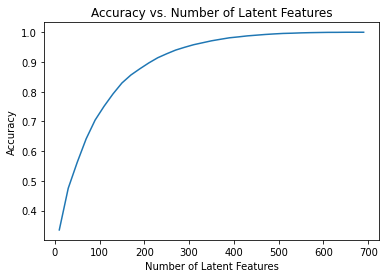

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    # creating the training and testing matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # extracting all user ids from training and testing data
    test_idx=df_test.groupby(['user_id'])['article_id'].count().index.tolist()
    test_arts=df_test.groupby(['article_id']).count().index.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [59]:
# testing area below for create_test_and_train_user_item
train_idx=df_train.groupby(['user_id'])['article_id'].count().index.tolist()
train_arts=df_train.groupby(['article_id']).count().index.tolist()
    
print('Number of users in test data: {}'.format(len(test_idx)))
print('Number of users in train data: {}'.format(len(train_idx)))
print('Number of articles in test data: {}'.format(len(test_arts)))
print('Number of articles in train data: {}'.format(len(train_arts)))


diff_test_train = np.setdiff1d(test_idx, train_idx)
diff_train_test = np.setdiff1d(train_idx, test_idx)
overlap_idx = list(set(test_idx).intersection(train_idx))
diff_arts = list(np.setdiff1d(test_arts, train_arts))
overlap_arts = list(set(test_arts).intersection(train_arts))

print('Users in test data, but not in train data: {}'. format(len(diff_test_train)))
print('Users in train data, but not in test data: {}'. format(len(diff_train_test)))
print('Users in both train and test data: {}'. format(len(overlap_idx)))
print('Articles in test data, but not in train data: {}'. format(len(diff_arts)))
print('Articles in both train and test data: {}'. format(len(overlap_arts)))

Number of users in test data: 682
Number of users in train data: 4487
Number of articles in test data: 574
Number of articles in train data: 714
Users in test data, but not in train data: 662
Users in train data, but not in test data: 4467
Users in both train and test data: 20
Articles in test data, but not in train data: 0
Articles in both train and test data: 574


In [60]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [61]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [62]:
# Use these cells to see how well you can use the training 

# separating the overlapping 20 users from both test and train data in a boolean array

#processing the rows
train_overlap_idx = user_item_train.index.isin(overlap_idx)
# we recreate u matrix based on the shapes for the overlapping users
u_test = u_train[train_overlap_idx, :]


#processing the columns
train_overlap_arts = user_item_train.columns.isin(overlap_arts)
# we recreate the v matrix based on the shapes for the overlapping users
vt_test = vt_train[:, train_overlap_arts]

#getting the matrix of the testing and training cropped as per the overlapping 20 users
user_item_test_overlap=user_item_test.loc[overlap_idx]
user_item_train_overlap=user_item_train.loc[overlap_idx]


print(u_test.shape)
print(vt_test.shape)

display(user_item_test_overlap)


(20, 4487)
(714, 574)


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
3968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Change the dimensions of u, s, and vt as necessary to use four latent features
# we compute a laten features list
from sklearn.metrics import accuracy_score

k_feat = np.arange(10,700+10,20)
#k_feat=[4, 10]

errs=[]
test_accuracy=[]
train_accuracy=[]

for k in k_feat:
    
    # updating the shapes of u, s, and vt matrices, based on the number of latent features , for the training data
    u_train_k = u_train[:, :k]
    s_train_k = np.zeros((k, k))
    s_train_k[:k, :k] = np.diag(s_train[:k]) 
    vt_train_k = vt_train[:k, :]
    
    # updating the shapes of u, vt matrices, based on the number of latent features , for the testing data
    u_test_k = u_test[:, :k]
    vt_test_k = vt_test[:k,:]
        
    # making predictions based on the matrices with defined latent features, fr the training data
    train_pred = np.round(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    
    # making predictions based on the matrices with defined latent features, fr the testing data
    test_pred = np.round(np.dot(np.dot(u_test_k, s_train_k), vt_test_k)) # we make sure to keep s_train_k, as sigma shows the correlation of the training components
    
    # Compute the error for each predicted vs. actual rating
    # sum_square_errs = (np.sum(np.sum((user_item_test_overlap - test_pred)**2)))
    
    err= (1 - ((np.sum(test_pred) + np.sum(np.sum(user_item_test_overlap)))/
               (user_item_test_overlap.shape[0]*user_item_test_overlap.shape[1])))
    errs.append(err)
    
    #Calculating the accuracy scores
    
    # flattening the matrices to get them to the vector shape of 1x1
    # below taken from https://www.geeksforgeeks.org/flatten-a-matrix-in-python-using-numpy/
    flatten_train = user_item_train.values.flatten()
    flatten_train_pred = train_pred.flatten()
    flatten_test_overlap = user_item_test_overlap.values.flatten()
    flatten_test_pred = test_pred.flatten()
    
    #Calculating the accuracy scores
    train_acc=accuracy_score(flatten_train, flatten_train_pred)
    test_acc=accuracy_score(flatten_test_overlap, flatten_test_pred)
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    

#print(errs)
#print(train_accuracy)
#print(test_accuracy)

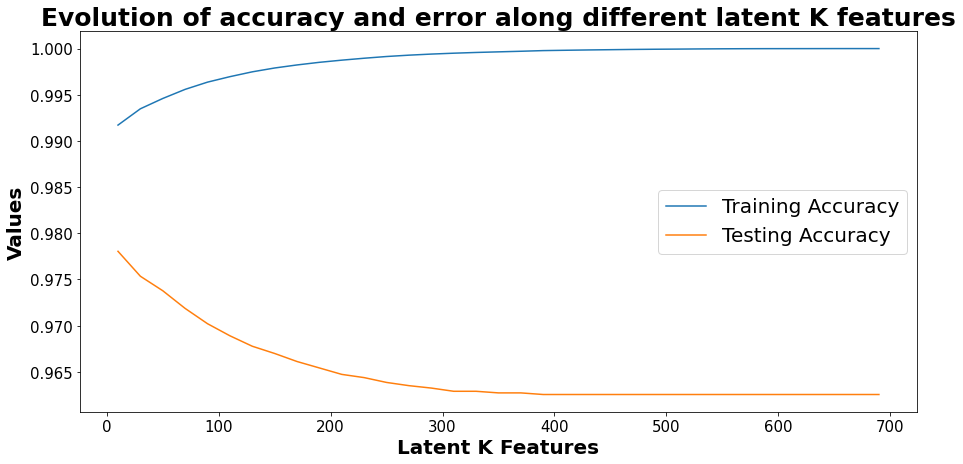

In [64]:
# plotting the results of our training and testing session
# below taken from https://howtothink.readthedocs.io/en/latest/PvL_H.html

plt.figure(figsize = (15, 7))
plt.plot(k_feat, train_accuracy, label='Training Accuracy')
plt.plot(k_feat, test_accuracy, label='Testing Accuracy')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Latent K Features', fontweight ='bold', fontsize = 20)
plt.ylabel('Values', fontweight ='bold', fontsize = 20)
plt.title('Evolution of accuracy and error along different latent K features', fontweight ='bold', fontsize = 25)
plt.legend(fontsize=20)
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.
The training accuracy increases with the incraese of our latent features, while the situation for our testing data is reversed: testing accuracy decreases severely with the increase of our latent features. 

This behaviour is specific to overfitting.

This means that our model learns the data while it performs the training on it, and it overfits itself on it.

In the same time, the testing accuracy reduces with the increase of latent features, which means that the model doesn't generalize well on testing data.

It seems that having more latent features does not help us in obtaining high accuracy on training and testing- also it seems that this entire approach for the recommendations- by using SVD- might not be the right one for creating the recommendations on this data set.

A reason for why our model performs so poorly in testing/real environment could be because we have very few overlapping users where we calculate the testing accuracy.

As well, the entire data set might be too rarely populated- meaning even though we have so many articles whith which users have interacted with, the number of interactions themselves is low.

A solution for this would be to collect more interactions: verify the time-frame in which these interactions have been collected, and increase this time-frame to get more of them, so that we may build a substantial interactions data set.

With more interactions, we also get a better base for our training and testing data sets, with maybe a bigger overlap between the 2 sets.**

In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1